## NOTE: These are the solutions, you should work on the other notebook to start!

# Advanced sampling techniques and packages

A tutorial by **Dan Foreman-Mackey** (CCA/Flatiron)

In this tutorial, we will go through the implementation of two MCMC problems using three popular Python packages for probabilistic inference: [emcee](https://emcee.readthedocs.io/en/latest/), [dynesty](https://dynesty.readthedocs.io/en/latest/), and [PyMC3](https://docs.pymc.io/).
One of the goals of this worksheet is to demonstrate the similarities and (expecially) differences between the usage and performance of the different packages.
These are all great libraries with different benefits and shortcomings and I'm hoping that, by the end of this tutorial, you will know some of the things that you need to know to choose the right tool for your specific project.
There are many other tools (even many others written in Python) that can be used for probabilistic inference, but I've chosen these three because they approximately span the range of general purpose tools that are commonly used in astro and they're the ones that I'm most familiar with.

Broadly speaking, the three packages can be roughly described as follows:

- *emcee* is a black box MCMC routine (it doesn't need your code to be written in a specific way) that doesn't require much tuning. It is going to be best suited to low dimensional problems (less than about 10 parameters) with a large dynamic range or significant covariances between the parameters. It doesn't scale well to high dimensional problems and multi-modal posterior densities can be seriously problematic. **Note**: For this tutorial, we'll be using a pre-release version emcee: 3.0. To install that version, run `pip install emcee==3.0rc2`.

- *dynesty* is a modern implementation of [nested sampling](https://en.wikipedia.org/wiki/Nested_sampling_algorithm) that works well for relatively low dimensional problems even if there are multiple modes in the posterior. Nested sampling is an algorithm for computing the "marginalized likelihood" or "evidence integral", but it also produces posterior samples (much like those produced by MCMC) as a byproduct. This is the feature that we'll be using today. *dynesty* and *emcee* have similar user interfaces so it shouldn't be too hard to switch between these two samplers in most cases.

- *PyMC3* is both a model building language and an MCMC engine. This can make the learning curve might be a bit steeper, but the initial legwork can be worth it in many cases. The main benefit of PyMC3 compared to the other libraries is that it scales much more efficiently to high dimensional problems. In many cases, PyMC3 can efficiently sample models with hundreds or thousands of parameters where the other samplers would really struggle. The biggest restriction when using PyMC3 is that you'll need to write your model using PyMC3's specific model building language. That means that you won't be able to easily use that Fortran code that your advisor's advisor wrote to evaluate your model. Sometimes this doesn't matter, but sometimes it does!

Below, we will go through two examples that demonstrate the usage of these libraries.

- The first example is one that you'll see in one form or another about a million times this week: fitting a line to data. This is a relatively simple problem that will help give you some intuition about the relationships between the different libraries. There is also a challenge problem that will help give some intuition for how you would go about generalizing these implementations.

- The second example is a more realistic problem (fitting radial velocity exoplanets) that will illustrate some real world issues that you'll run into when fitting real data, and give some ideas for how to deal with them.

## Set up the environment and import

To start, let's set up our environment (so that the plots look a little nicer) and make sure that we can import all of the modules that we're going to need.

In [1]:
%matplotlib inline

In [2]:
# There are a bunch of functions useful for this tutorial implemented in the
# advanced_sampling_utils.py file that should be in the same directory as
# this notebook.
from advanced_sampling_utils import setup_plotting
setup_plotting()

In [3]:
# Basic scientific Python modules 
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# For plotting: https://corner.readthedocs.io
import corner

# Sampling modules:
import emcee
import dynesty
import pymc3 as pm

# This is needed for our second pymc3 example below
import theano.tensor as tt

If any errors appeared, let me know and we'll work it out.
If not, we're good to go!

## Example 1: Fitting a line to data using emcee, dynesty, and PyMC3

In this example, we're going to fit a line to data, but we'll make it very slightly non-trivial by fitting for the amplitude of the noise as well as the slope and intercept of the line.
This problem has been written about [all](https://arxiv.org/abs/1008.4686) [over](https://emcee.readthedocs.io/en/latest/tutorials/line/) [the](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) [place](https://dynesty.readthedocs.io/en/latest/examples.html#linear-regression), and you'll hear a few other discussions of it this week, but we'll start with a quick summary of the model so that we have consistent notation.

The model that we'll fit has three parameters: the slope $m$, the intercept $b$, and the logarithm of the size of errorbar $\log \sigma$.
**Note**: here and thoughout this tutorial, $\log$ means the natural logarithm, not $\log_{10}$.
For some setting of these parameters, let's simulate some fake data:

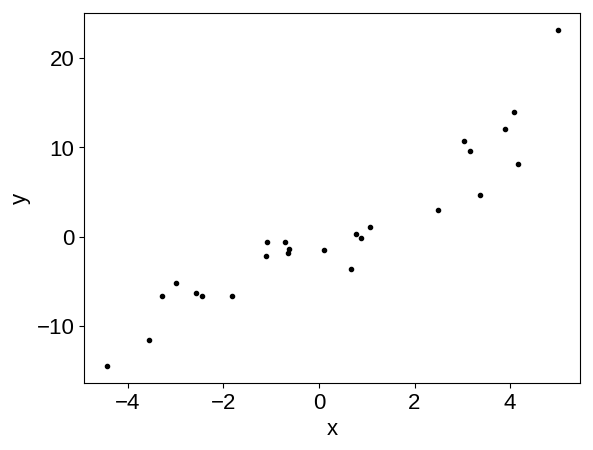

In [4]:
np.random.seed(502489)

m_true = 3.1
b_true = -0.01
logs_true = np.log(3.5)
x = np.random.uniform(-5, 5, 25)
y = m_true * x + b_true + np.exp(logs_true)*np.random.randn(len(x))

plt.plot(x, y, ".k")
plt.xlabel("x")
plt.ylabel("y");

### The model

Instead of fitting these parameters directly, following [the advice from this blogpost](https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/), we'll fit using the angle between the line and a horizontal line $\theta = \arctan m$, and the "perpendicular intercept" $b_\perp = b\,\cos\theta$.

After specifying the parameterization, we must then specify the prior and likelihood functions (or, more specifically, the logarithm of these functions).
We're going to choose a separable prior:

$$
p(b_\perp,\,\theta,\,\log\sigma) = p(b_\perp)\,p(\theta)\,p(\log \sigma)
$$

and we will use uniform priors for each of these parameters:

$$
\log p(b_\perp) = \left\{\begin{array}{ll}\log(1/20) & \mathrm{if}\,-10 < b_\perp < 10 \\
-\infty & \mathrm{otherwise}\end{array}\right.
$$

$$
\log p(\theta) = \left\{\begin{array}{ll}\log(1/\pi) & \mathrm{if}\,-\pi/2 < \theta < \pi/2 \\
-\infty & \mathrm{otherwise}\end{array}\right.
$$

$$
\log p(\log \sigma) = \left\{\begin{array}{ll}\log(1/20) & \mathrm{if}\,-10 < \log \sigma < 10 \\
-\infty & \mathrm{otherwise}\end{array}\right.
$$

Then, we will assume Gaussian uncertainties with standard deviation $\sigma$ for the observation model.
In this case, the (log-) likelihood function is:

$$
\log p(\{y_n\}\,|\,\{x_n\},\,b_\perp,\,\theta,\,\log\sigma) = -\frac{1}{2}\sum_{n=1}^N \left[\frac{(y_n - m\,x_n - b)^2}{\sigma^2} + \log(2\,\pi\,\sigma^2)\right]
$$

where $m$ and $b$ are computed as $m = \tan(\theta)$ and $b = b_\perp / \cos\theta$.

This is now enough information to start implementing the fits.

### An implementation in emcee

The only function that emcee requires to run MCMC is a function that takes a vector of parameters ($b_\perp$, $\theta$, and $\log\sigma$, in this case) and returns the log probability (evaluated up to a constant) for those parameters.
However, it is often useful to separate the problem a little more than that.
In the following cell, you should implement the following 4 functions:

- `emcee_get_params(params)` that takes a vector of parameters (`bperp`, `theta`, and `logs`) and returns the parameters that the model needs: `m`, `b`, and `logs`.
- `emcee_logprior(params)` that takes a vector of parameters (`bperp`, `theta`, and `logs`) and returns the value of the log prior function (up to a constant, the normalization doesn't matter). This function should reject parameter sets that are outside of the allowed prior range by returning `-np.inf`.
- `emcee_loglike(params)` that takes a vector of parameters (`bperp`, `theta`, and `logs`) and returns the value of the log likelihood function (up to a constant).
- `emcee_logprob(params)` that takes a vector of parameters (`bperp`, `theta`, and `logs`) and returns the value of the log posterior probability (up to a constant). This should be implemented as the sum of the output from `emcee_logprior` and `emcee_loglike`, and I've actually already inserted an implementation that should work, but you might want to double check to make sure that it does the right thing when the parameters are outside of the prior bounds (return `-np.inf` if the log prior value is `-np.inf`).

At the bottom of the cell, there is a set of unit tests that will check your implementation to make sure that your implementation is correct.
If you see any errors below, try to fix the function that is failing the test.

In [5]:
def emcee_get_params(params):
    #
    # YOUR CODE GOES HERE
    #
    bperp, theta, logs = params
    m = np.tan(theta)
    b = bperp / np.cos(theta)
    return m, b, logs

def emcee_logprior(params):
    #
    # YOUR CODE GOES HERE
    #
    bperp, theta, logs = params
    if not -10 < bperp < 10:
        return -np.inf
    if not -0.5*np.pi < theta < 0.5*np.pi:
        return -np.inf
    if not -10 < logs < 10:
        return -np.inf
    return 0.0

def emcee_loglike(params):
    #
    # YOUR CODE GOES HERE
    #
    m, b, logs = emcee_get_params(params)
    model = m * x + b
    return -0.5 * np.sum((y - model)**2 / np.exp(2*logs) + 2*logs)

def emcee_logprob(params):
    # I've actually implemented this function here for you
    lp = emcee_logprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + emcee_loglike(params)


# Now we run the unit tests to make sure that the functions are implemented correctly
from advanced_sampling_utils import test_emcee_functions    
test_emcee_functions(emcee_get_params, emcee_logprior, emcee_loglike, emcee_logprob, x, y)

Testing 'emcee_get_params'... PASSED! :)
Testing 'emcee_logprior'... PASSED! :)
Testing 'emcee_loglike'... PASSED! :)
Testing 'emcee_logprob'... PASSED! :)


In the following cell, we'll go through the steps to initialize and run our sampling.
This includes the following steps (and tuning parameter choices):

1. First, we need to initialize our sampler. For emcee, we need to select a point in parameter space for each "walker" in the ensemble. In this case, we'll use 100 walkers (I chose that number pretty arbitrarily), but you might find that you get better performance using a different choice. We'll initialize the walker coordinates by choosing a valid point in the parameter space and then add a small Gaussian random number to each walker coordinate so that they're not right on top of each other.

2. Next, we run our MCMC starting from the initial coordinates. For now, we'll just run 4000 steps, but you might want to use [an automated convergence test](https://emcee.readthedocs.io/en/latest/tutorials/monitor/) when you use this in your research.

In [6]:
np.random.seed(9281)
init = np.array([0.0, 0.0, 0.0])
init = init + 0.1 * np.random.randn(100, 3)

emcee_sampler = emcee.EnsembleSampler(len(init), 3, emcee_logprob)
emcee_sampler.run_mcmc(init, 4000, progress=True);

100%|██████████| 4000/4000 [00:12<00:00, 315.79it/s]


After running an MCMC, it's always a good idea to run some convergence diagnostics.
With emcee, the recommended convergence diagnostic is [the integrated autocorrelation time](https://emcee.readthedocs.io/en/latest/tutorials/autocorr/).
To get an estimate for the autocorrelation time for the chain for each parameter (**Note**: there isn't just one autocorrelation time per sampling, there's one for each scalar that you want to compute from the chain), we can use the `get_autocorr_time` method:

In [7]:
tau = emcee_sampler.get_autocorr_time()
print("Integrated autocorrelation times:")
for i, k in enumerate(["bperp", "theta", "logs"]):
    print("{0}: {1}".format(k, tau[i]))

Integrated autocorrelation times:
bperp: 36.82077511168997
theta: 43.852978781638676
logs: 31.390594987086857


Next, let's discard approximately 5 autocorrelation times worth of samples as "burn-in" (the phase where the sampler "forgets" about its initialization) and then estimate the number of effective samples.

In [8]:
tau_max = int(tau.max())
emcee_samples = emcee_sampler.get_chain(discard=5*tau_max, flat=True)
emcee_samples = np.array(emcee_get_params(emcee_samples.T)).T

print("Effective number of samples for each parameter:")
print(len(emcee_samples) / emcee_sampler.get_autocorr_time(discard=5*tau_max))

Effective number of samples for each parameter:
[10173.25493569 10020.83600189 10635.99608221]


That's a lot of samples! (Probably more than we need...)

Then it can also be useful to plot the [corner plot](https://corner.readthedocs.io/en/latest/) for the sampling to visualize the covariances between the parameters.
Since this fit was based on simulated data, we can also overplot the true values of the parameters; it looks like we recovered the truth!

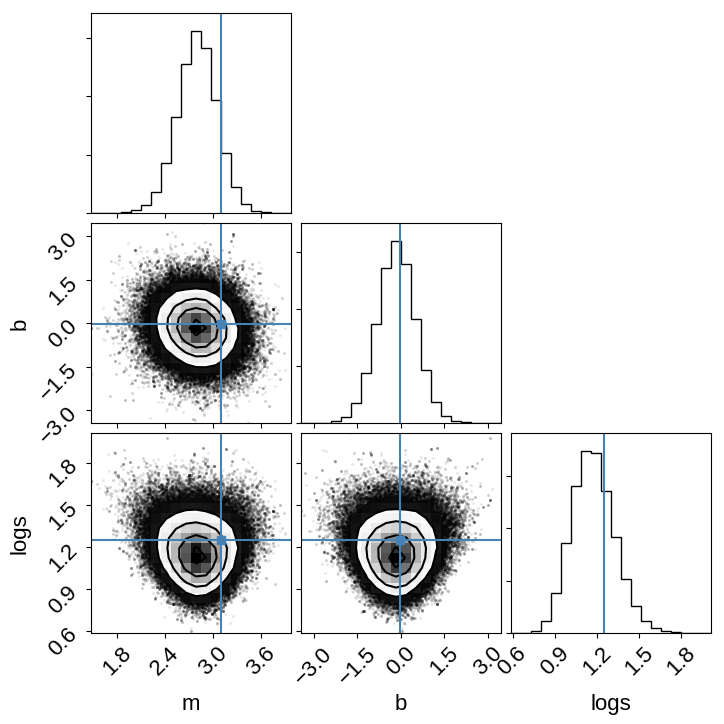

In [9]:
corner.corner(emcee_samples, labels=["m", "b", "logs"],
              truths=[m_true, b_true, logs_true]);

One last plot that can be good to look at is the posterior *prediction* of the model.
In this case, that would be a representation of the lines that are consistent with the data.
There are two different ways that I like to represent this: (a) as samples (using the `plt.plot` function with the `alpha` parameter) or (b) as a contour (using the `plt.fill_between` function).
Select one or two of these options and make a plot below with the data and the posterior lines overplotted.
If you choose to make a contour, a common choice would be to fill the area between the 16th and 84th percentiles of the posterior (check out the `np.percentile` function).

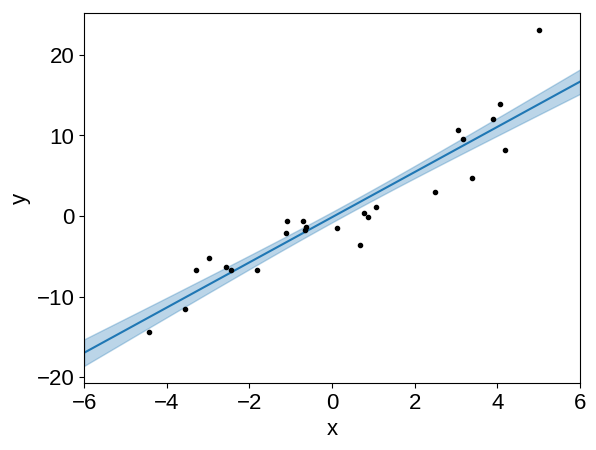

In [10]:
#
# YOUR CODE GOES HERE
#
x0 = np.linspace(-6, 6, 100)
lines = emcee_samples[:, 0] * x0[:, None] + emcee_samples[:, 1]
q = np.percentile(lines, [16, 50, 84], axis=1)
plt.fill_between(x0, q[0], q[2], color="C0", alpha=0.3)
plt.plot(x0, q[1], color="C0")
plt.xlim(-6, 6)

plt.plot(x, y, ".k")
plt.xlabel("x")
plt.ylabel("y");

### An implementation in dynesty

Now let's update our model to use it with *dynesty*.
The only new function that we need to implement is a function called `dynesty_prior_transform` that takes samples on the unit cube and converts them to the parameter space that we're sampling.
The [dynesty docs for this function are here](https://dynesty.readthedocs.io/en/latest/quickstart.html#prior-transforms).
This particular example is pretty simple, we need to convert 3 numbers in the range `[0, 1]` to three numbers in the ranges `[-10, 10]`, `[-pi/2, pi/2]`, and `[-10, 10]` respectively.

As above, implement your prior transform function below.
It should take a numpy array with three elements in the range `[0, 1]` and it should return a numpy array with entries `(bperp, theta, logs)`.
Once your implementation is correct, the unit test should pass.

In [11]:
def dynesty_prior_transform(u):
    #
    # YOUR CODE GOES HERE
    #
    bperp = -10 + 20 * u[0]
    theta = -0.5*np.pi + np.pi * u[1]
    logs = -10 + 20 * u[2]
    return np.array([bperp, theta, logs])

def dynesty_get_params(params):
    # This function is the same as the one above for emcee...
    return emcee_get_params(params)

def dynesty_loglike(params):
    # So is this one!
    return emcee_loglike(params)

# Now we run the unit tests to make sure that the functions are implemented correctly
from advanced_sampling_utils import test_dynesty_functions    
test_dynesty_functions(dynesty_get_params, dynesty_prior_transform, dynesty_loglike, x, y)

Testing 'dynesty_get_params'... PASSED! :)
Testing 'dynesty_prior_transform'... PASSED! :)
Testing 'dynesty_loglike'... PASSED! :)


Once all your tests pass, let's run the nested sampling algorithm.
Unlike emcee, dynesty doesn't require an initialization step. Instead, it will start by sampling from the prior.
Also unlike emcee, dynesty uses a convergence diagnostic as a stopping criterion so you won't choose the number of model evaluations that the sampler will perform.
Instead, you can tune the convergence criteria [following the documentation here](https://dynesty.readthedocs.io/en/latest/dynamic.html).
After the sampler converges, we re-sample the results using the `resample_equal` function in order to get effectively independent samples from the posterior density.

In [12]:
# Run the sampler
np.random.seed(3028)
dynesty_sampler = dynesty.NestedSampler(dynesty_loglike, dynesty_prior_transform, 3)
dynesty_sampler.run_nested()

# Resample the results to get samples from the posterior
dynesty_results = dynesty_sampler.results
dynesty_samples = dynesty.utils.resample_equal(
    dynesty_results.samples, np.exp(dynesty_results.logwt - dynesty_results.logz[-1])
)
dynesty_samples = np.array(dynesty_get_params(dynesty_samples.T)).T

print("Effective number of samples:")
print(len(dynesty_samples))

iter: 6175 | +500 | bound: 24 | nc: 1 | ncall: 35704 | eff(%): 18.695 | loglstar:   -inf < -40.186 <    inf | logz: -51.750 +/-  0.212 | dlogz:  0.001 >  0.509                                       

Effective number of samples:
6675


In the following cells, make the two results plots that are equivalent for the ones above: the corner plot and the posterior predictions.
Studying these plots, convince yourself that the results are the same and try to understand/explain any differences.

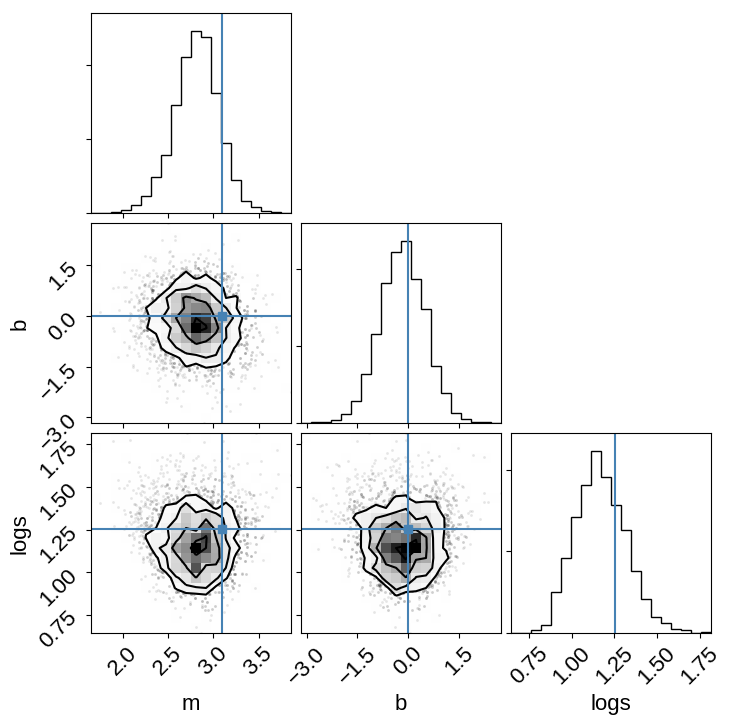

In [13]:
corner.corner(dynesty_samples, labels=["m", "b", "logs"],
              truths=[m_true, b_true, logs_true]);

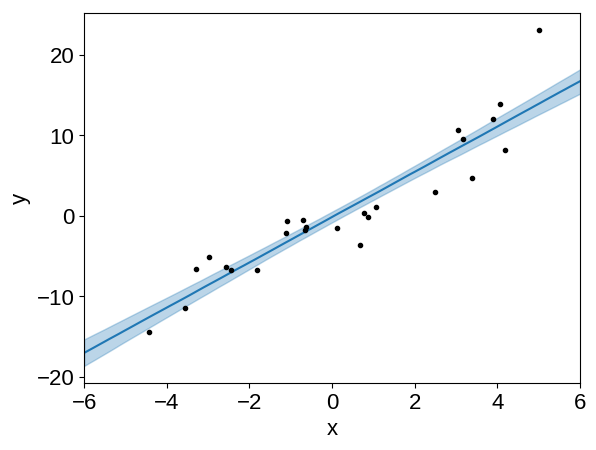

In [14]:
x0 = np.linspace(-6, 6, 100)
lines = dynesty_samples[:, 0] * x0[:, None] + dynesty_samples[:, 1]
q = np.percentile(lines, [16, 50, 84], axis=1)
plt.fill_between(x0, q[0], q[2], color="C0", alpha=0.3)
plt.plot(x0, q[1], color="C0")
plt.xlim(-6, 6)

plt.plot(x, y, ".k")
plt.xlabel("x")
plt.ylabel("y");

### An implementation in PyMC3

Finally, let's implement the same fit using PyMC3.
The PyMC3 modeling interface is very different than the interface to emcee and dynesty, and I've found that the learning curve can be somewhat steeper, but it can be very powerful once you learn it!

One major difference is that you won't be implementing a function that evaluates the log probability.
Instead, you should define [the *distribution* for each parameter](https://docs.pymc.io/api/distributions.html) and the relationships between them.
For example, since the $b_\perp$ (`bperp`) parameter should have a uniform prior between -10 and 10, we should write:

```python
bperp = pm.Uniform("bperp", lower=-10, upper=10)
```

to define that variable.
Similarly, the *likelihood* will be defined as a distribution (a `pm.Normal` in this case) with the `observed` parameter set to the data - that's how we *condition* on the observations.

Another distribution that will come in handy is the `pm.Deterministic` distribution.
This let's us track the value of some parameters for each step in the chain without re-computing them afterwards.
For example, we want to track that value of the slope `m` for each step.
To do that, we would write:

```python
m = pm.Deterministic("m", pm.math.tan(theta))
```

since $m = \tan\theta$.

You should note here that we didn't use `np.tan`.
That's because *we cannot use numpy functions with pymc3 objects*.
Instead, we must use the math functions defined in `pm.math` or `theano.tensor` which we imported above as `tt`.
`pm.math` has many of the mathematical functions that we need, but if something isn't included in that module, it's worth looking at the [mathematical functions defined in theano.tensor](http://deeplearning.net/software/theano/library/tensor/basic.html#mathematical) to see if it's there.

In the cell below, implement the model using PyMC3.
It should have 3 parameters with uniform prior distributions: (1) `bperp`, (2) `theta`, and (3) `logs`.
It should also have two `pm.Deterministic` parameters for `m` and `b` calculated using `pm.math` or `theano.tensor`.
Finally, it should have a `pm.Normal` distribution with the `observed` parameter set.

Here are some links that might be useful references:

1. [PyMC3 getting started](https://docs.pymc.io/getting_started.html),
2. [PyMC3 tutorials](https://docs.pymc.io/nb_tutorials/index.html), and
3. [Intro to PyMC3 from exoplanet](http://exoplanet.dfm.io/en/stable/tutorials/intro-to-pymc3/).

Once you have your model implemented, it should pass the unit test below.

In [15]:
# Your model needs to be *inside* this pm.Model "context manager":
with pm.Model() as pymc3_model:
    
    bperp = pm.Uniform("bperp", lower=-10, upper=10)
    
    #
    # YOUR CODE GOES HERE
    #
    theta = pm.Uniform("theta", lower=-0.5*np.pi, upper=0.5*np.pi)
    logs = pm.Uniform("logs", lower=-10, upper=10)

    m = pm.Deterministic("m", pm.math.tan(theta))
    b = pm.Deterministic("b", bperp / pm.math.cos(theta))
    model = m * x + b
        
    pm.Normal("loglike", mu=model, sd=pm.math.exp(logs), observed=y)

from advanced_sampling_utils import test_pymc3_model
test_pymc3_model(pymc3_model, x, y)

Testing 'pymc3_model'... PASSED! :)


To sample using PyMC3, you will sometimes need to provide an initial guess for the parameters.
This is often best done using the `testval` argument in the distribution specifications (as you'll see below), but for this model, we can just sample starting from the default values.
So we'll just sample using the `pm.sample` function which will use the [No U-Turn Sampling](https://arxiv.org/abs/1111.4246) algorithm to generate samples from the posterior density.
We need to specify the number of samples to run as burn-in (called `tune` in PyMC3) where the parameters of the sampler are automatically adjusted to improve the performance of the sampling.
Then you'll also need to specify the number of samples to run for the final chain after burn-in completes (this parameter is called `draws`).
There are a lot of tuning parameters for this algorithm so you'll want to run more burn-in steps than you might expect from your previous experience.
As a useful starting point, I've found that setting `tune` and `draws` to the same value is generally about right.
In this case, we'll use `5000` steps for both `tune` and `draws`.

In [16]:
with pymc3_model:
    np.random.seed(802941)
    trace = pm.sample(tune=5000, draws=5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs, theta, bperp]
Sampling 2 chains, 0 divergences: 100%|██████████| 20000/20000 [00:09<00:00, 2201.77draws/s]


As usual, after running our sampler, we should check some convergence diagnostics.
With PyMC3, we'll use the `pm.summary` function:

In [17]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bperp,-0.046442,0.222737,0.002402,-0.462537,0.416791,9802.485321,1.000036
theta,1.226146,0.028018,0.000286,1.168199,1.276842,9901.182631,0.999932
logs,1.167786,0.153241,0.001739,0.880410,1.476199,8530.652769,0.999938
m,2.804272,0.240200,0.002344,2.319380,3.267677,10504.545288,0.999948
b,-0.144099,0.657133,0.006909,-1.410143,1.189846,10091.411141,1.000028


For our purposes, you should mainly pay attention to the `n_eff` and `Rhat` columns.
The `Rhat` column is the $\hat{R}$ statistic from [Brooks & Gelman (1998)](http://www.stat.columbia.edu/~gelman/research/published/brooksgelman2.pdf) and it should be close to 1 for a converged chain.
The `n_eff` column provides an estimate of the effective number of samples for each parameter.

In the cells below, make the two results plots like above (the `pm.trace_to_dataframe` function can be useful, but it's not necessary).

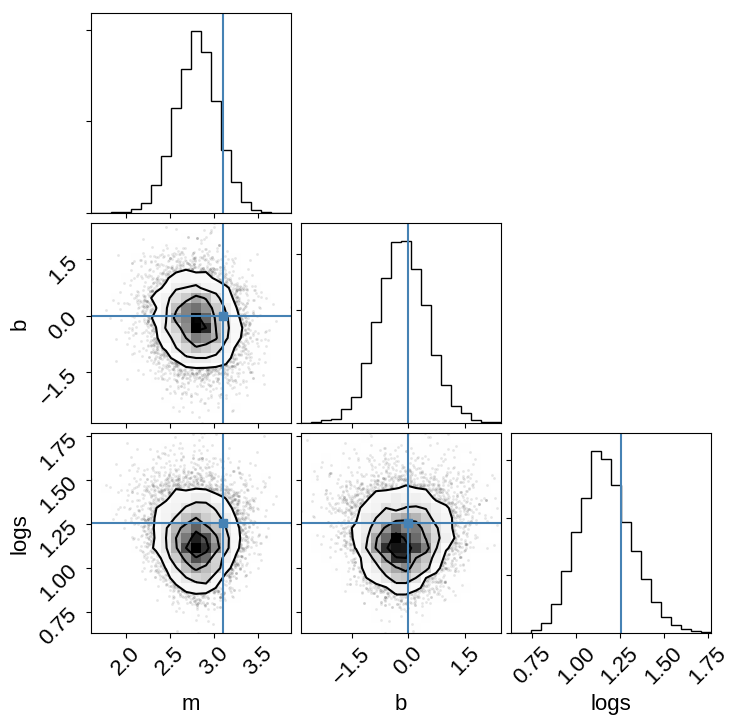

In [18]:
pymc3_samples = pm.trace_to_dataframe(trace, varnames=["m", "b", "logs"])
corner.corner(pymc3_samples, truths=[m_true, b_true, logs_true]);

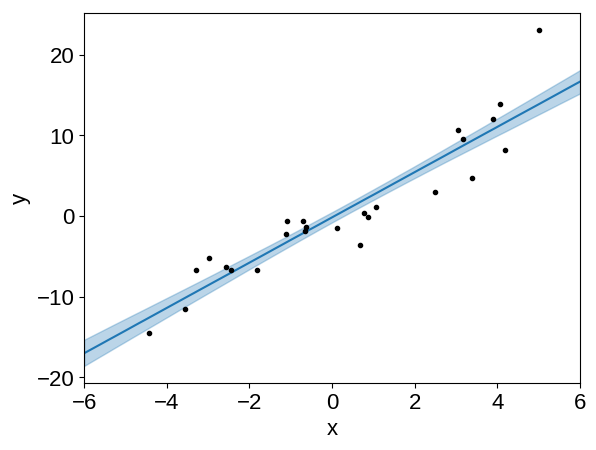

In [19]:
x0 = np.linspace(-6, 6, 100)
lines = trace["m"] * x0[:, None] + trace["b"]
q = np.percentile(lines, [16, 50, 84], axis=1)
plt.fill_between(x0, q[0], q[2], color="C0", alpha=0.3)
plt.plot(x0, q[1], color="C0")
plt.xlim(-6, 6)

plt.plot(x, y, ".k")
plt.xlabel("x")
plt.ylabel("y");

### Challenge problem: uncertain x coordinates

A reasonable generalization of the above example is to include support for uncertainties on the $x$ coordinates.
There has been quite a bit written on this topic - including [a blog post that I wrote](https://dfm.io/posts/fitting-a-plane/) - and there is cleverness that you can use to simplify the problem.
But in this problem, you should choose one of the three samplers above and generalize your implementation to include $N$ new parameters $\hat{x}_n$ (where $N$ is the number of datapoints) and $\hat{x}_n$ is the "true" value of $x_n$ that you're fitting.
You can use any of the three sampling libraries, but this is a case where PyMC3 really shines (so that's what I'd suggest trying!).

Here's a new simulated dataset where the $x$ coordinates are given by `xobs` with uncertainty `xerr`:

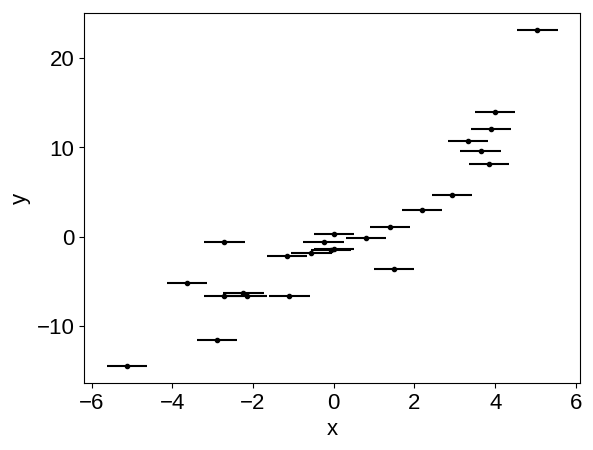

In [20]:
np.random.seed(69302)
xerr = 0.5
xobs = x + xerr * np.random.randn(len(x))
plt.errorbar(xobs, y, xerr=xerr, fmt=".k")
plt.xlabel("x")
plt.ylabel("y");

100%|██████████| 30000/30000 [02:13<00:00, 225.06it/s]


Effective number of samples for each parameter:
[5934.02764263 6174.15229087 6121.85242555 6253.08560253 6124.8748942
 6701.65167219 6826.90427305 6323.77244949 6770.4643591  6481.22851421
 6307.23256126 6693.83894759 6577.07641339 6520.50351926 7074.46614609
 6506.66115248 6380.15682063 6754.33286939 6308.58231281 6464.70341812
 6619.44031291 6382.81583328 6360.52630233 6375.63704954 6151.35217127
 6594.4603801  6685.26005483 6292.125492  ]


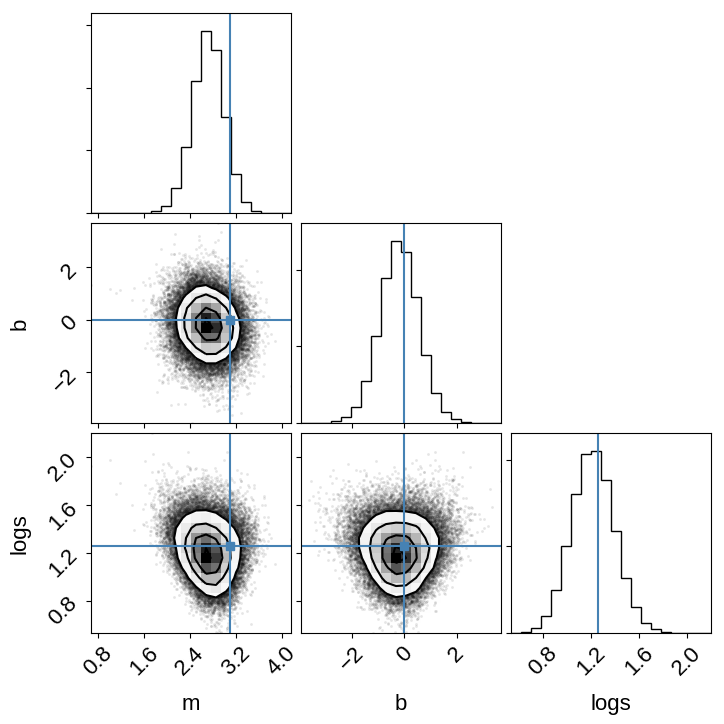

In [31]:
#
# This is my solution to the challenge problem using emcee
#

def emcee_logprior2(params):
    lp = emcee_logprior(params[:3])
    if not np.isfinite(lp):
        return lp
    lp += -0.5 * np.sum((xobs - params[3:])**2) / xerr**2
    return lp

def emcee_loglike2(params):
    m, b, logs = emcee_get_params(params[:3])
    xtrue = params[3:]
    model = m * xtrue + b
    return -0.5 * np.sum((y - model)**2 / np.exp(2*logs) + 2*logs)

def emcee_logprob2(params):
    lp = emcee_logprior2(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + emcee_loglike2(params)

np.random.seed(123)
init = np.append([0.0, 0.0, 0.0], xobs)
init = init + 0.1 * np.random.randn(100, len(init))

emcee_sampler2 = emcee.EnsembleSampler(init.shape[0], init.shape[1], emcee_logprob2)
state = emcee_sampler2.run_mcmc(init, 30000, progress=True)

thin = 50
emcee_samples2 = emcee_sampler2.get_chain(flat=True, thin=thin, discard=1000)
emcee_samples2 = np.array(emcee_get_params(emcee_samples2[:, :3].T)).T

print("Effective number of samples for each parameter:")
print(thin * len(emcee_samples2) / emcee_sampler2.get_autocorr_time(thin=thin, discard=1000))

corner.corner(emcee_samples2, labels=["m", "b", "logs"],
              truths=[m_true, b_true, logs_true]);

iter: 9554 | +500 | bound: 168 | nc: 1 | ncall: 6061886 | eff(%):  0.166 | loglstar:   -inf < -35.804 <    inf | logz: -54.419 +/-  0.271 | dlogz:  0.001 >  0.509                                    

Effective number of samples:
10054


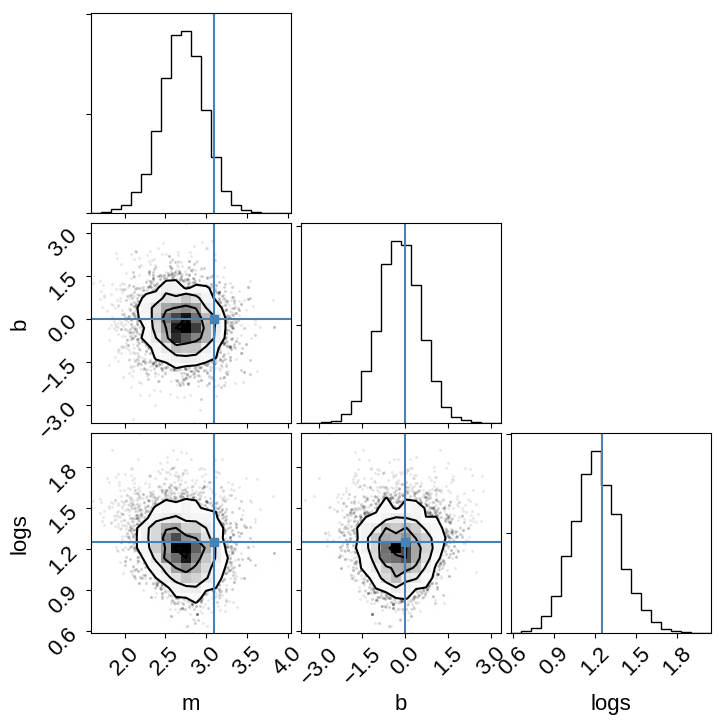

In [22]:
#
# This is my solution to the challenge problem using dynesty
#

def dynesty_prior_transform2(u):
    bperp = -10 + 20 * u[0]
    theta = -0.5*np.pi + np.pi * u[1]
    logs = -10 + 20 * u[2]
    xtrue = xobs + scipy.stats.norm.ppf(u[3:], scale=xerr)
    return np.append([bperp, theta, logs], xtrue)

def dynesty_loglike2(params):
    return emcee_loglike2(params)

np.random.seed(543002)

dynesty_sampler2 = dynesty.NestedSampler(dynesty_loglike2, dynesty_prior_transform2, 3 + len(xobs))
dynesty_sampler2.run_nested()

dynesty_results2 = dynesty_sampler2.results
dynesty_samples2 = dynesty.utils.resample_equal(
    dynesty_results2.samples, np.exp(dynesty_results2.logwt - dynesty_results2.logz[-1])
)
dynesty_samples2 = np.array(dynesty_get_params(dynesty_samples2[:, :3].T)).T

print("Effective number of samples:")
print(len(dynesty_samples2))

corner.corner(dynesty_samples2, labels=["m", "b", "logs"],
              truths=[m_true, b_true, logs_true]);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs, theta, bperp, xtrue]
Sampling 2 chains, 0 divergences: 100%|██████████| 20000/20000 [00:16<00:00, 1247.42draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
xtrue__0,2.770482,0.470883,0.003098,1.857295,3.707891,23042.819722,0.999900
xtrue__1,0.037272,0.467195,0.003186,-0.846618,0.977668,26789.307469,0.999900
xtrue__2,5.545974,0.493681,0.003796,4.598812,6.534047,18076.244927,0.999903
xtrue__3,2.039279,0.469791,0.003147,1.110419,2.950998,23082.017465,0.999971
xtrue__4,1.093317,0.489034,0.003176,0.167346,2.094291,17730.592909,0.999900
xtrue__5,-2.669682,0.464308,0.002724,-3.560868,-1.734412,23411.911148,0.999903
xtrue__6,-0.557777,0.460682,0.002926,-1.444819,0.362107,20895.441231,0.999939
xtrue__7,-1.278513,0.457631,0.002769,-2.181034,-0.395741,22991.831671,0.999933
xtrue__8,-3.365197,0.477176,0.003323,-4.272168,-2.419404,21432.570414,1.000030
xtrue__9,-0.059299,0.468083,0.003329,-0.939488,0.886418,20542.955278,0.999909


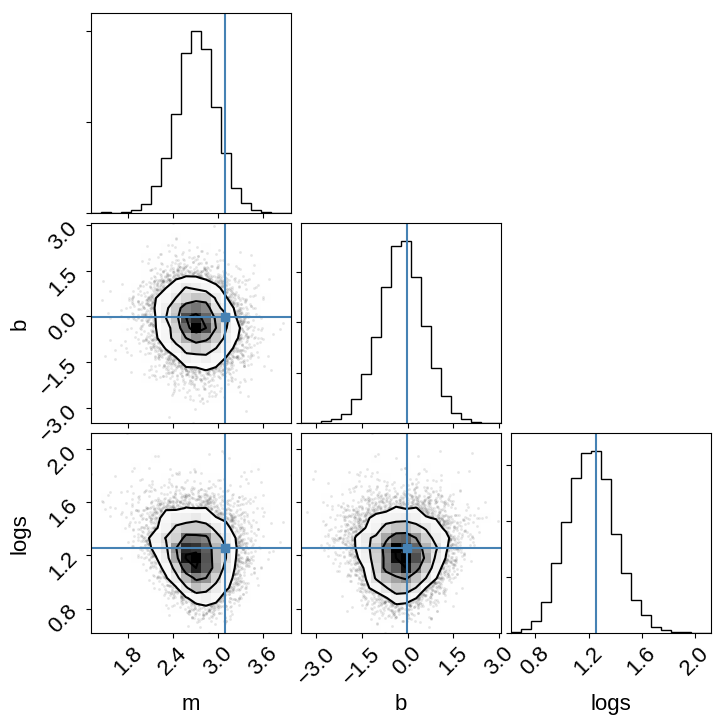

In [23]:
#
# This is my solution to the challenge problem using pymc3
#

with pm.Model() as pymc3_model2:
    
    xtrue = pm.Normal("xtrue", mu=xobs, sd=xerr, shape=len(xobs))
    
    bperp = pm.Uniform("bperp", lower=-10, upper=10)
    theta = pm.Uniform("theta", lower=-0.5*np.pi, upper=0.5*np.pi)
    logs = pm.Uniform("logs", lower=-10, upper=10)

    m = pm.Deterministic("m", pm.math.tan(theta))
    b = pm.Deterministic("b", bperp / pm.math.cos(theta))
    model = m * xtrue + b
        
    pm.Normal("loglike", mu=model, sd=pm.math.exp(logs), observed=y)
    
    np.random.seed(13958)
    trace2 = pm.sample(tune=5000, draws=5000)
    
pymc3_samples2 = pm.trace_to_dataframe(trace2, varnames=["m", "b", "logs"])
corner.corner(pymc3_samples2, truths=[m_true, b_true, logs_true]);

pm.summary(trace2)

## Example 2: Radial velocity exoplanets (ish)

In this example, we'll fit a somewhat more realistic example where we will fit for the periods, phases, and amplitudes of two sine waves in a one dimensional dataset.
This isn't terribly compelling, so let's call the independent coordinate "time" and the dependent coordinate "radial velocity", then the problem becomes the estimation of the periods and semi-amplitudes of two planets orbiting a star observed with radial velocities.

First let's simulate the dataset:

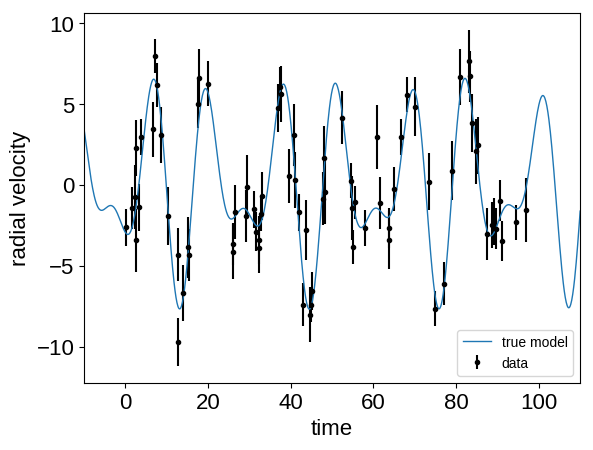

In [24]:
# A simple radial velocity model
def rv_model(amps, periods, phases, t, math=np):
    t = np.reshape(t, list(np.shape(t)) + [1] * len(np.shape(amps)))
    rv = amps * math.sin(2*np.pi*t / periods + phases)
    return math.sum(rv, axis=-1)

# Set the true parameters
np.random.seed(21048)
true_periods = np.array([10.5, 15.6])
true_amps = np.array([3.1049, 4.560])
true_phases = np.random.uniform(-np.pi, np.pi, len(true_periods))

# Simulate the data
t = np.random.uniform(0, 100, 78)
v = rv_model(true_amps, true_periods, true_phases, t)
verr = np.random.uniform(1.0, 2.0, len(t))
v = v + verr * np.random.randn(len(t))
plt.errorbar(t, v, yerr=verr, fmt=".k", label="data")

# Plot the true model
t0 = np.linspace(-10, 110, 1000)
v0 = rv_model(true_amps, true_periods, true_phases, t0)
plt.plot(t0, v0, label="true model", lw=1)

plt.xlim(t0.min(), t0.max())
plt.legend(fontsize=10)
plt.xlabel("time")
plt.ylabel("radial velocity");

The likelihood function in this case is:

$$
p(\{v_n\}\,|\,\{t_n\},\,\{A_j\},\,\{P_j\},\,\{\phi_j\}) = \prod_{n=1}^N \mathrm{Normal}(v_n\,|\,\mu_n,\,\sigma_n)
$$

where

$$
\mu_n = \sum_{j=1}^J A_j\,\sin\left(\frac{2\,\pi\,t_n}{P_j} + \phi_j\right)
$$

and the parameters are the amplitudes $A_j$, periods $P_j$, and phases $\phi_j$ for each planet.

You should also select reasonable priors for each of these parameters (perhaps uniform or uniform in the log).

### Implementation

Then in the following cells, *implement this fit using at least one of the above samplers* (or another if you have a favorite).
If you have time, it is worth implementing the fit using dynesty and one of the other two samplers to compare your results.

In all cases, some care should be taken to implement periodic boundary conditions for $\phi$. One option is to reparameterize using $u_j = \sqrt{A_j}\,\sin\phi_j$ and $w_j = \sqrt{A_j}\,\cos\phi_j$ instead of $A_j$ and $\phi_j$ directly. (Can you convince yourself that this will have the right prior on $A_j$ and $\phi_j$?) Another option is to parameterize in terms of $A_j$, $u_j \sim \mathrm{Normal}(0,\,1)$, and $w_j \sim \mathrm{Normal}(0,\,1)$ and then define $\phi_j = \arctan(u_j / w_j)$. This is the parameterization that I would use with PyMC3 and it is implemented as the `Angle` distribution in the `advanced_sampling_utils` module. If you're using dynesty, you can use the `periodic` parameter when initializing the `NestedSampler`.

100%|██████████| 15000/15000 [01:33<00:00, 161.00it/s]


Effective number of samples for each parameter:
[17403.13457757 18274.674669   16621.92178939 18184.3200722
 19053.23708895 18459.47591726]


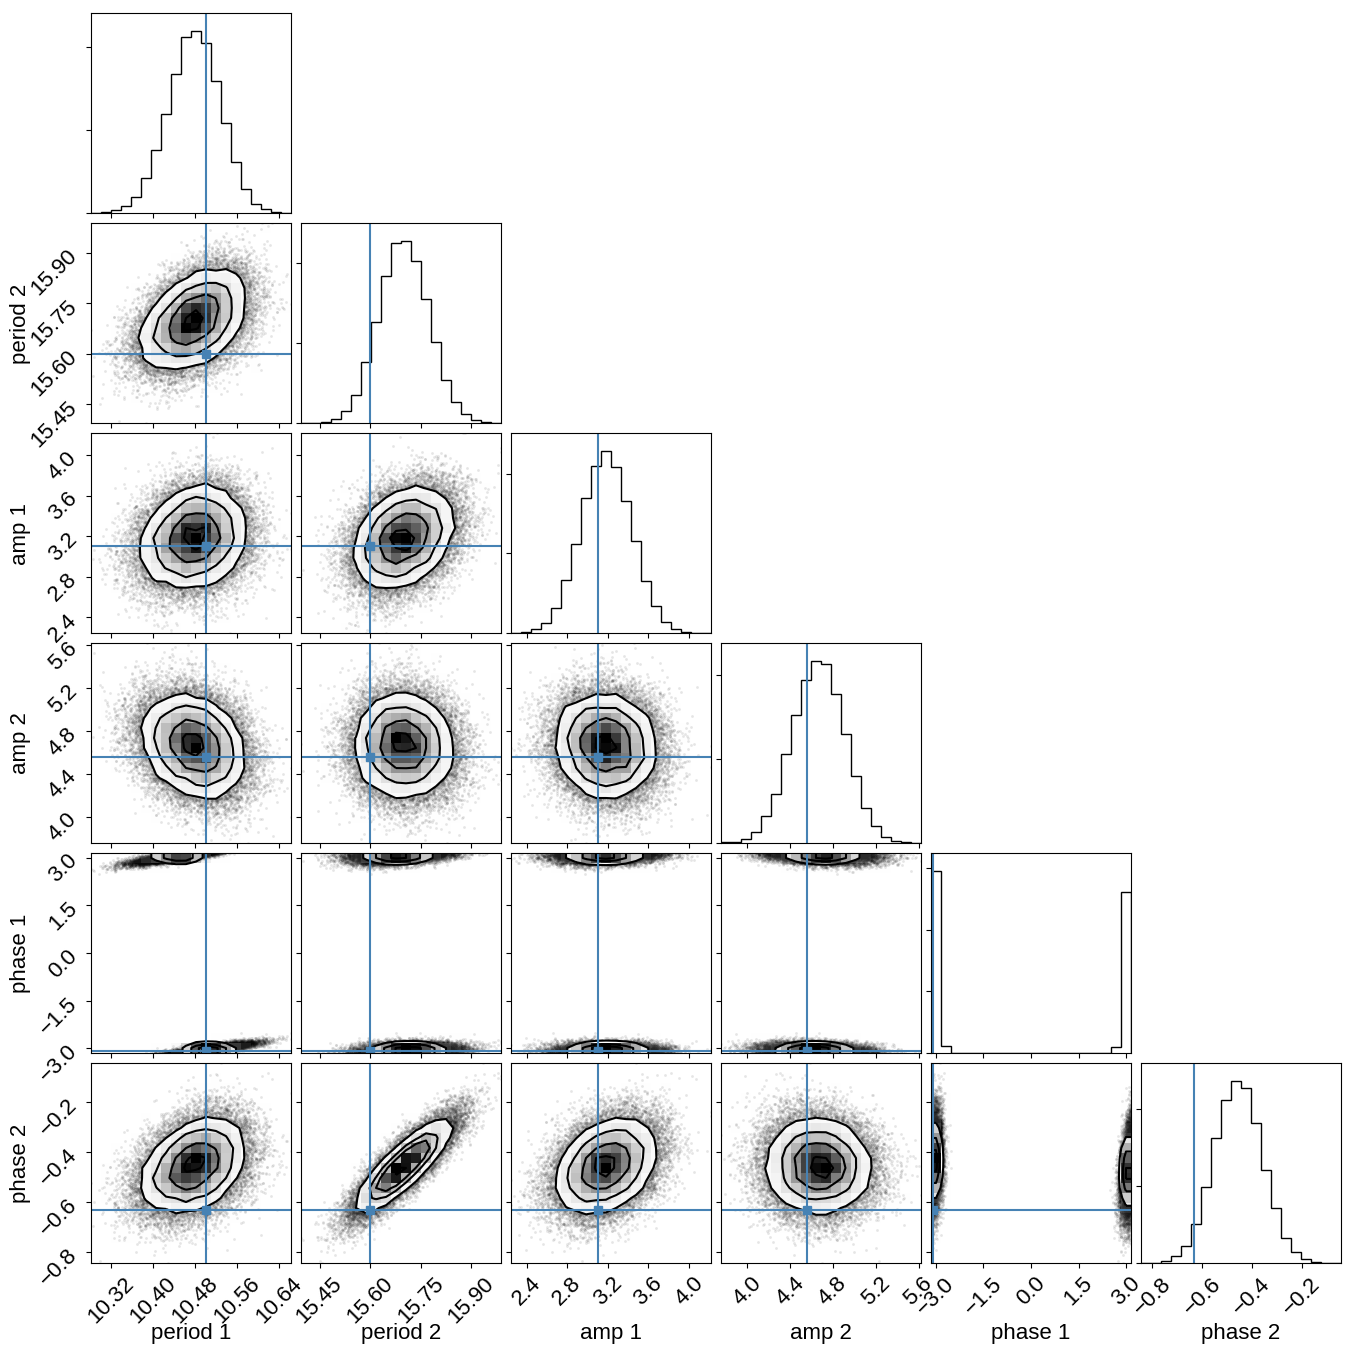

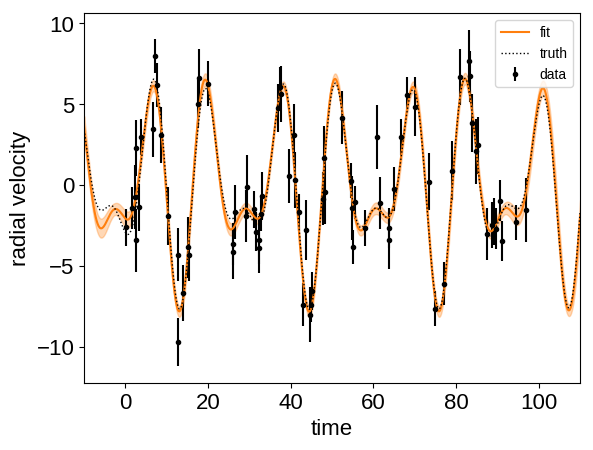

In [25]:
#
# This is my solution to the RV problem using emcee
#

# Set up the model as above
def emcee_logprior_rv(params):
    periods, amps, phases = emcee_get_params_rv(params)
    if np.any(periods < 5.0) or np.any(20.0 < periods):
        return -np.inf
    if np.any(amps < 0.1) or np.any(10.0 < amps):
        return -np.inf
    return 0.0

def emcee_get_params_rv(params):
    log_periods = params[:2]
    sqrt_amp_sin_phases = params[2:4]
    sqrt_amp_cos_phases = params[4:6]
    periods = np.exp(log_periods)
    amps = sqrt_amp_sin_phases**2 + sqrt_amp_cos_phases**2
    phases = np.arctan2(sqrt_amp_sin_phases, sqrt_amp_cos_phases)
    return periods, amps, phases

def emcee_loglike_rv(params):
    periods, amps, phases = emcee_get_params_rv(params)
    model = rv_model(amps, periods, phases, t)
    return -0.5 * np.sum(((v - model) / verr)**2)

def emcee_logprob_rv(params):
    lp = emcee_logprior_rv(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + emcee_loglike_rv(params)

# Initialize somewhere reasonable - how about near the true values? :)
np.random.seed(9281)
init = np.concatenate((
    np.log(true_periods),
    np.sqrt(true_amps) * np.sin(true_phases),
    np.sqrt(true_amps) * np.cos(true_phases))
)
init = init + 1e-6 * np.random.randn(100, len(init))

# Run the sampler
emcee_sampler_rv = emcee.EnsembleSampler(len(init), init.shape[1], emcee_logprob_rv)
emcee_sampler_rv.run_mcmc(init, 15000, progress=True)

# Estimate the number of effective samples
thin = 50
emcee_samples_rv = emcee_sampler_rv.get_chain(flat=True, thin=thin, discard=500)
emcee_samples_rv = np.concatenate(emcee_get_params_rv(emcee_samples_rv.T)).T
print("Effective number of samples for each parameter:")
print(thin * len(emcee_samples_rv) / emcee_sampler_rv.get_autocorr_time(thin=thin, discard=500))

# Plot the corner plot
corner.corner(emcee_samples_rv, labels=["period 1", "period 2", "amp 1", "amp 2", "phase 1", "phase 2"],
              truths=np.concatenate((true_periods, true_amps, true_phases)));

# Plot the posterior prediction
plt.figure()
plt.errorbar(t, v, yerr=verr, fmt=".k", label="data")

vsamp = rv_model(emcee_samples_rv[:, 2:4], emcee_samples_rv[:, :2], emcee_samples_rv[:, 4:], t0)
q = np.percentile(vsamp, [16, 50, 84], axis=1)

plt.fill_between(t0, q[0], q[2], color="C1", edgecolor="none", alpha=0.3)
plt.plot(t0, q[1], color="C1", label="fit")
plt.plot(t0, v0, ":k", label="truth", lw=1)

plt.xlim(t0.min(), t0.max())
plt.legend(fontsize=10)
plt.xlabel("time")
plt.ylabel("radial velocity");

iter: 10696 | +500 | bound: 310 | nc: 1 | ncall: 277755 | eff(%):  4.031 | loglstar:   -inf < -38.084 <    inf | logz: -58.798 +/-  0.290 | dlogz:  0.001 >  0.509                                    

Effective number of samples:
11196


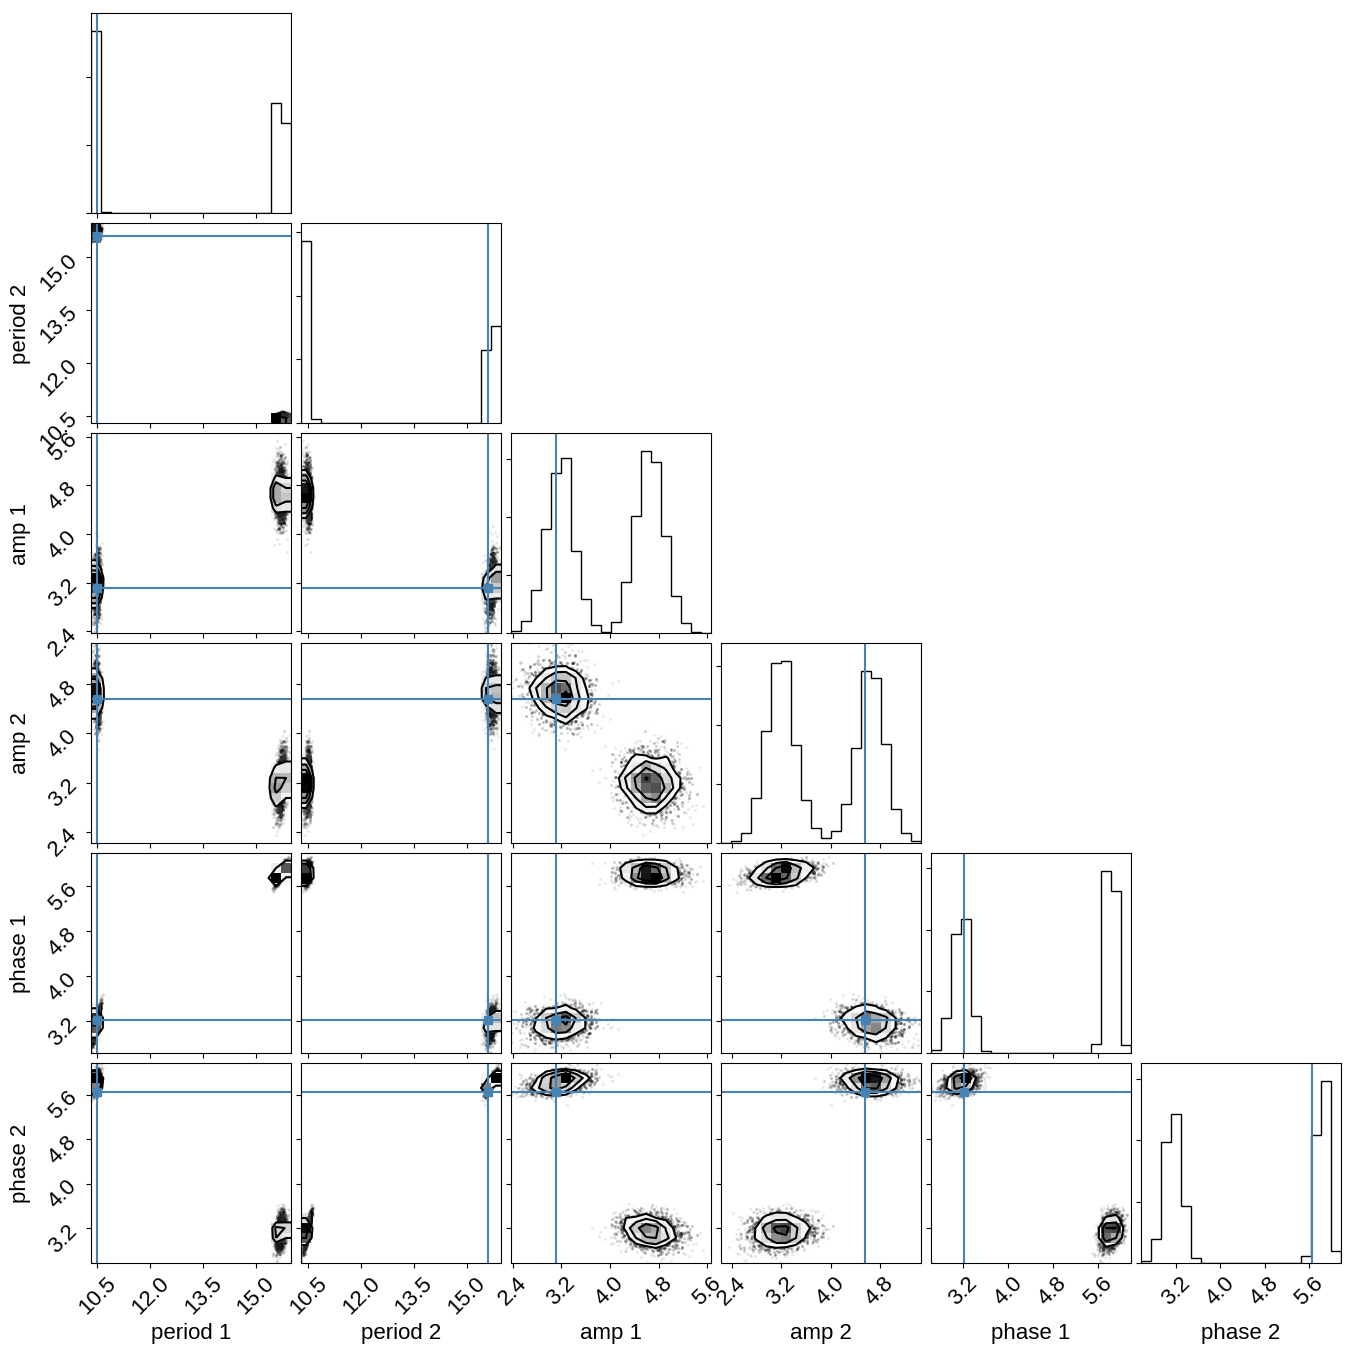

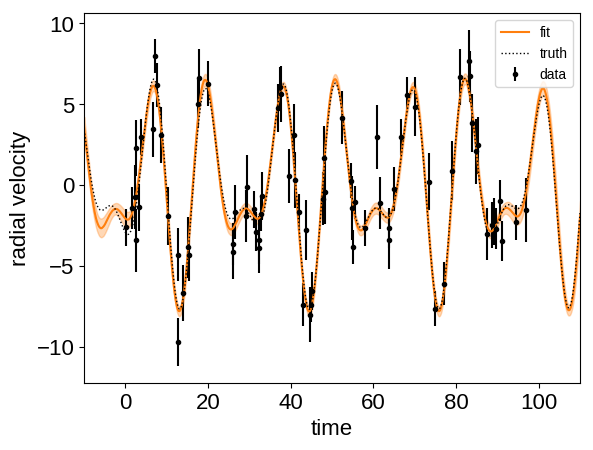

In [26]:
#
# This is my solution to the RV problem using dynesty
#

def dynesty_prior_transform_rv(u):
    params = np.empty_like(u)
    params[:2] = np.log(5) + (np.log(20) - np.log(5)) * u[:2]
    params[2:4] = 0.1 + (10 - 0.1) * u[2:4]
    params[4:] = 2 * np.pi * (u[4:] % 1.0)
    return params

def dynesty_get_params_rv(params):
    log_periods = params[:2]
    amps = params[2:4]
    phases = params[4:]
    periods = np.exp(log_periods)
    return periods, amps, phases

def dynesty_loglike_rv(params):
    periods, amps, phases = dynesty_get_params_rv(params)
    model = rv_model(amps, periods, phases, t)
    return -0.5 * np.sum(((v - model) / verr)**2)

# Run the sampler
np.random.seed(857930)
dynesty_sampler_rv = dynesty.NestedSampler(dynesty_loglike_rv, dynesty_prior_transform_rv, 6, periodic=[4, 5])
dynesty_sampler_rv.run_nested()

# Resample the chains
dynesty_results_rv = dynesty_sampler_rv.results
dynesty_samples_rv = dynesty.utils.resample_equal(
    dynesty_results_rv.samples, np.exp(dynesty_results_rv.logwt - dynesty_results_rv.logz[-1])
)
dynesty_samples_rv = np.concatenate(dynesty_get_params_rv(dynesty_samples_rv.T)).T

# Estimate the number of effective samples
print("Effective number of samples:")
print(len(dynesty_samples_rv))

# Plot the corner plot
corner.corner(dynesty_samples_rv, labels=["period 1", "period 2", "amp 1", "amp 2", "phase 1", "phase 2"],
              truths=np.concatenate((true_periods, true_amps, true_phases % (2*np.pi))));

# Plot the posterior prediction
plt.figure()
plt.errorbar(t, v, yerr=verr, fmt=".k", label="data")

vsamp = rv_model(dynesty_samples_rv[:, 2:4], dynesty_samples_rv[:, :2], dynesty_samples_rv[:, 4:], t0)
q = np.percentile(vsamp, [16, 50, 84], axis=1)

plt.fill_between(t0, q[0], q[2], color="C1", edgecolor="none", alpha=0.3)
plt.plot(t0, q[1], color="C1", label="fit")
plt.plot(t0, v0, ":k", label="truth", lw=1)

plt.xlim(t0.min(), t0.max())
plt.legend(fontsize=10)
plt.xlabel("time")
plt.ylabel("radial velocity");

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [phases, amps, log_periods]
INFO:pymc3:NUTS: [phases, amps, log_periods]
Sampling 2 chains, 0 divergences: 100%|██████████| 20000/20000 [00:49<00:00, 403.90draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
log_periods__0,2.349239,0.004705,0.000063,2.339922,2.358253,6396.536443,1.000010
log_periods__1,2.753679,0.004652,0.000049,2.744989,2.763129,10610.650068,0.999931
periods__0,10.477710,0.049286,0.000655,10.380429,10.572468,6401.420799,1.000011
periods__1,15.700452,0.073051,0.000770,15.564450,15.849357,10610.526122,0.999931
amps__0,3.183960,0.245548,0.002449,2.686700,3.656779,11848.022540,0.999949
amps__1,4.663954,0.243599,0.002385,4.199937,5.152155,12339.252194,0.999904
phases__0,-0.185935,3.015966,0.037015,-3.122005,3.141239,7373.986631,0.999914
phases__1,-0.454869,0.095675,0.001039,-0.639255,-0.267632,10319.790109,0.999900


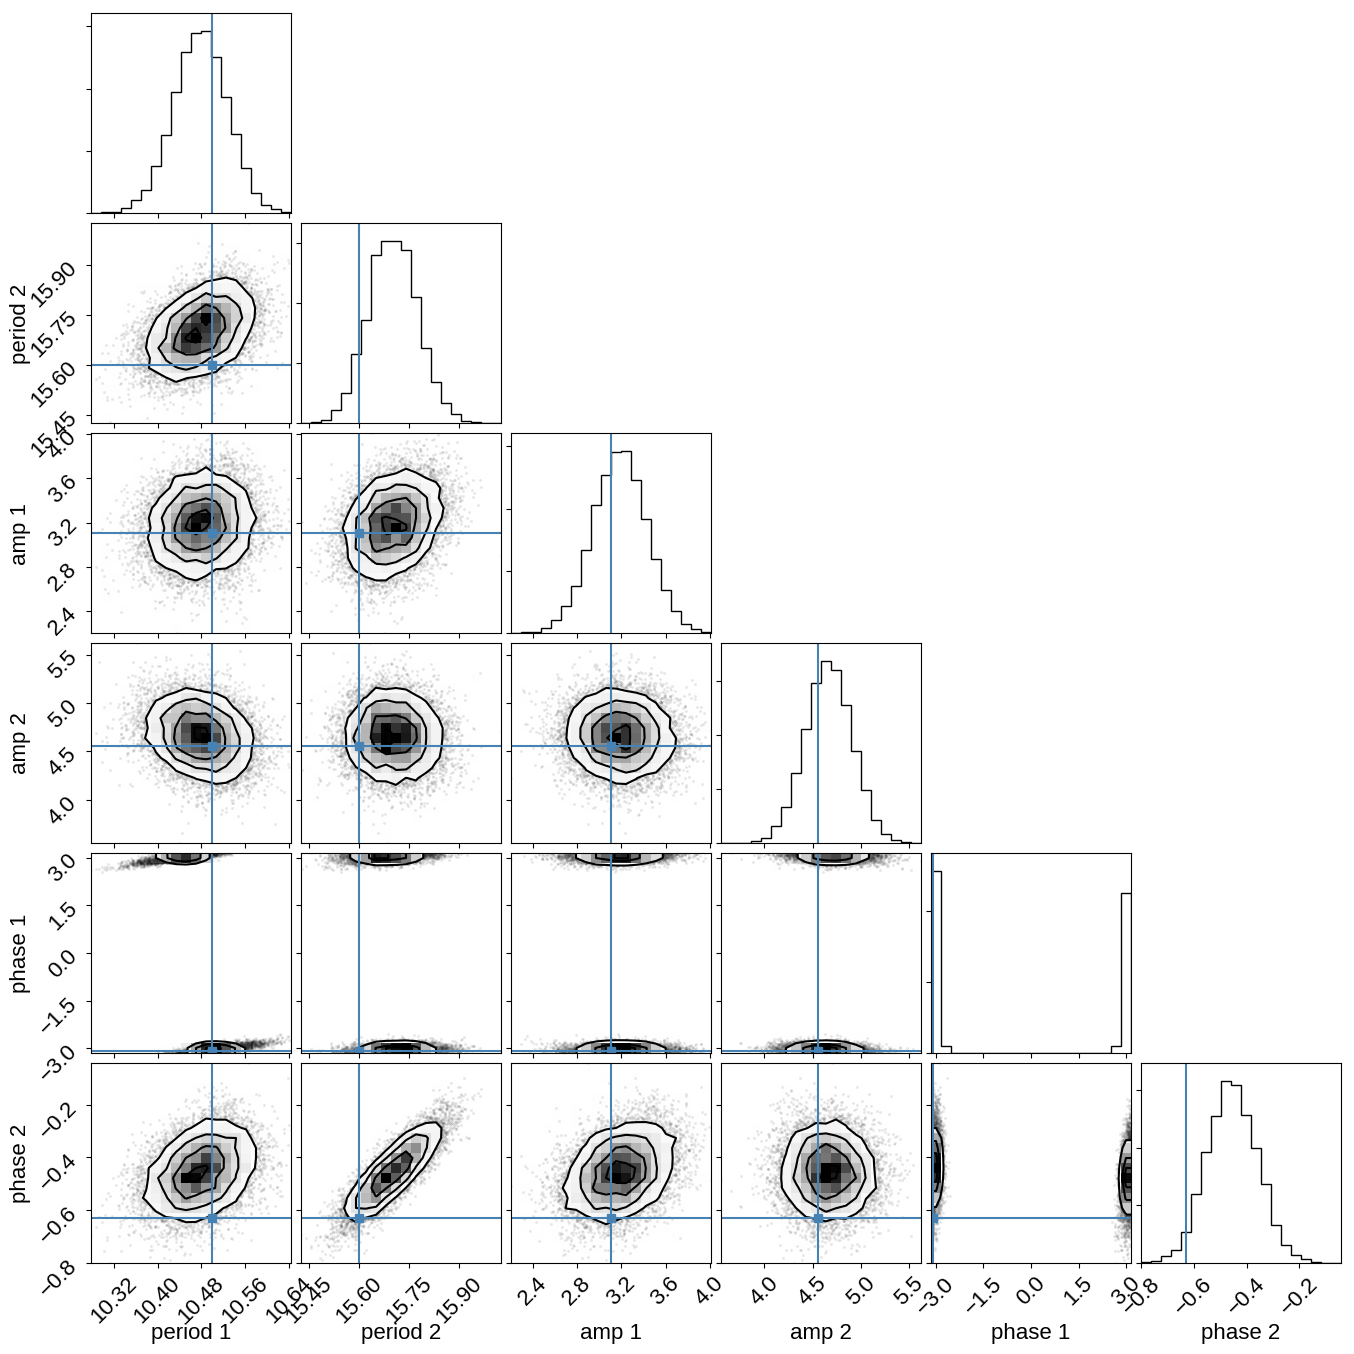

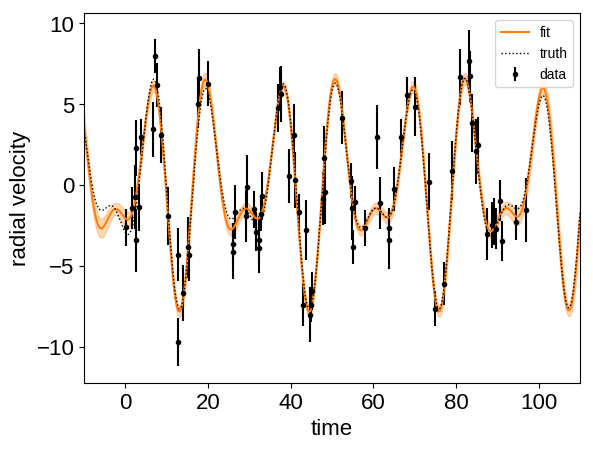

In [30]:
#
# This is my solution to the RV problem using pymc3
#

from advanced_sampling_utils import Angle

with pm.Model() as pmyc3_model_rv:
    
    # Here I'm constraining the periods to be sorted to break the labelling degeneracy
    log_periods = pm.Uniform("log_periods", lower=np.log(5), upper=np.log(20), shape=2,
                             testval=np.log(true_periods),
                             transform=pm.distributions.transforms.ordered)
    periods = pm.Deterministic("periods", tt.exp(log_periods))
    amps = pm.Uniform("amps", lower=0.1, upper=10, shape=2, testval=true_amps)
    phases = Angle("phases", shape=2, testval=true_phases)
    
    model = amps[None, :] * tt.sin(2*np.pi*t[:, None] / periods[None, :] + phases[None, :])
    model = tt.sum(model, axis=1)

    pm.Normal("obs", mu=model, sd=verr, observed=v)
    
    trace_rv = pm.sample(tune=5000, draws=5000, start=pmyc3_model_rv.test_point, target_accept=0.9)
    
# Plot the corner plot
pymc3_samples_rv = pm.trace_to_dataframe(trace_rv, varnames=["periods", "amps", "phases"])
corner.corner(pymc3_samples_rv, labels=["period 1", "period 2", "amp 1", "amp 2", "phase 1", "phase 2"],
              truths=np.concatenate((true_periods, true_amps, true_phases)))    

# Plot the posterior prediction
plt.figure()
plt.errorbar(t, v, yerr=verr, fmt=".k", label="data")

vsamp = rv_model(trace_rv["amps"], trace_rv["periods"], trace_rv["phases"], t0)
q = np.percentile(vsamp, [16, 50, 84], axis=1)

plt.fill_between(t0, q[0], q[2], color="C1", edgecolor="none", alpha=0.3)
plt.plot(t0, q[1], color="C1", label="fit")
plt.plot(t0, v0, ":k", label="truth", lw=1)

plt.xlim(t0.min(), t0.max())
plt.legend(fontsize=10)
plt.xlabel("time")
plt.ylabel("radial velocity")

# Check the convergence
pm.summary(trace_rv)

### Questions to think about

Try to debug your sampling until you get something convincing.
Once you do, try comparing the plots you made to the solutions.
When doing that, consider these questions:

1. Are results consistent with my solutions?
2. Do the results look consistent across the different methods? If not, why?
3. What degeneracies can you identfy in this problem and how might you mitigate them?